In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, ConcatDataset
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import cv2

# read the input image
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01/Gender01/train/male/JPCLN001.png')

# image properties
print("Type:",type(img))
print("Shape of Image:", img.shape)
print('Total Number of pixels:', img.size)
print("Image data type:", img.dtype)

# print("Pixel Values:\n", img)
print("Dimension:", img.ndim)

Type: <class 'numpy.ndarray'>
Shape of Image: (256, 256, 3)
Total Number of pixels: 196608
Image data type: uint8
Dimension: 3


In [ ]:
gender_data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01/Gender01',
    '/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01_Index/Gender01_Index',
    '/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01_RGB/Gender01_RGB'
]

# Define transformations
gender_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  # Increased rotation range
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random cropping
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomErasing(p=0.5),  # Randomly erases part of the image
    transforms.ToTensor(),
])


# Function to load datasets
def gender_load_dataset(gender_data_dir):
    return {
        'train': datasets.ImageFolder(
            os.path.join(gender_data_dir, 'train'),
            transform=gender_data_transforms
        ),
        'test': datasets.ImageFolder(
            os.path.join(gender_data_dir, 'test'),
            transform=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
        )
    }

# Initialize empty lists for train and test datasets
gender_train_datasets = []
gender_test_datasets = []

# Load datasets from each directory
for dir in gender_data_dirs:
    datasets_dict = gender_load_dataset(dir)
    gender_train_datasets.append(datasets_dict['train'])
    gender_test_datasets.append(datasets_dict['test'])

# Concatenate datasets
combined_gender_train_dataset = ConcatDataset(gender_train_datasets)
combined_gender_test_dataset = ConcatDataset(gender_test_datasets)

# Create DataLoaders
gender_dataloaders = {
    'train': DataLoader(combined_gender_train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'test': DataLoader(combined_gender_test_dataset, batch_size=32, shuffle=False, num_workers=2),
}

In [ ]:
gender_dataset_sizes = {x: len(gender_dataloaders[x].dataset) for x in ['train', 'test']}
gender_dataset_sizes

{'train': 462, 'test': 279}

In [ ]:
class_names = gender_train_datasets[0].classes
class_names

['female', 'male']

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Increased learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [ ]:
# Training loop
num_epochs = 50
total_step = len(gender_dataloaders['train'])

for epoch in range(num_epochs):
    model.train()

    for i, (inputs, labels) in enumerate(gender_dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 15 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')

    scheduler.step()

Epoch [1/50], Step [15/15], Loss: 0.0565
Epoch [2/50], Step [15/15], Loss: 0.1003
Epoch [3/50], Step [15/15], Loss: 0.1581
Epoch [4/50], Step [15/15], Loss: 0.1308
Epoch [5/50], Step [15/15], Loss: 0.2108
Epoch [6/50], Step [15/15], Loss: 0.1089
Epoch [7/50], Step [15/15], Loss: 0.3373
Epoch [8/50], Step [15/15], Loss: 0.0755
Epoch [9/50], Step [15/15], Loss: 0.2715
Epoch [10/50], Step [15/15], Loss: 0.1232
Epoch [11/50], Step [15/15], Loss: 0.2785
Epoch [12/50], Step [15/15], Loss: 0.1733
Epoch [13/50], Step [15/15], Loss: 0.2321
Epoch [14/50], Step [15/15], Loss: 0.2963
Epoch [15/50], Step [15/15], Loss: 0.3120
Epoch [16/50], Step [15/15], Loss: 0.1591
Epoch [17/50], Step [15/15], Loss: 0.0991
Epoch [18/50], Step [15/15], Loss: 0.1181
Epoch [19/50], Step [15/15], Loss: 0.0746
Epoch [20/50], Step [15/15], Loss: 0.1317
Epoch [21/50], Step [15/15], Loss: 0.1410
Epoch [22/50], Step [15/15], Loss: 0.1425
Epoch [23/50], Step [15/15], Loss: 0.1471
Epoch [24/50], Step [15/15], Loss: 0.1875
E

In [ ]:
def resnet18_test():
    model.eval()
    correct = 0
    total = 0


    for images, labels in gender_dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        test_output = model(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()

        total += labels.size(0)
        correct += (pred_y == labels).sum().item()

    accuracy = 100 * correct / total
    print('Test Accuracy of the model on the test images: {:.2f}%'.format(accuracy))



In [ ]:
resnet18_test()

Test Accuracy of the model on the test images: 68.10%


In [ ]:
import random

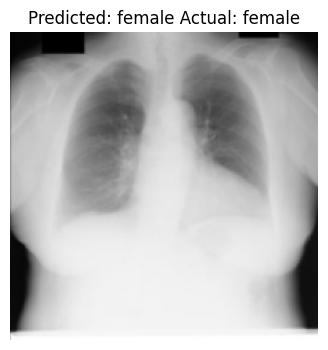

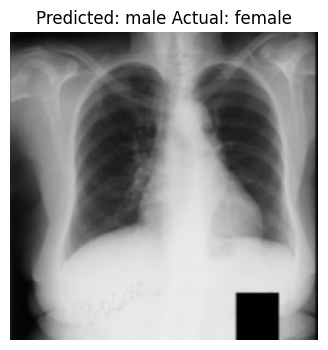

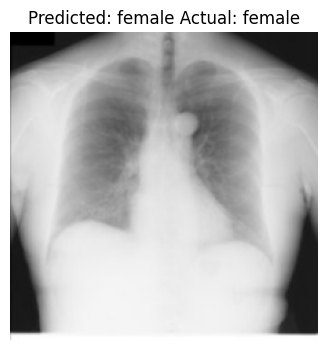

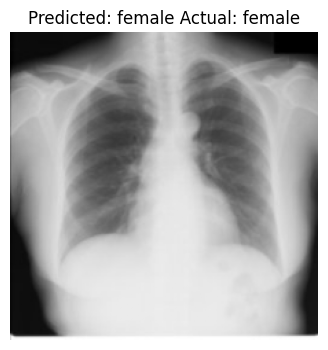

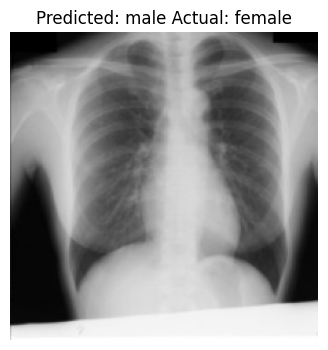

In [ ]:


def imshow(inp, title=None, figsize=(4, 4)):
    """Display the image with a smaller size."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=figsize)  # Set the figure size to make the photo smaller
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axes for better visualization
    plt.pause(0.001)  # Pause to allow the plot to be updated

# Get a batch of images and labels from the test DataLoader
inputs, classes = next(iter(gender_dataloaders['test']))

# Move inputs to the appropriate device
inputs = inputs.to(device)

# Get model predictions
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Randomly select a few images to display
num_images = 5  # Number of images to display
selected_indices = random.sample(range(inputs.size(0)), num_images)

# Display the randomly selected images
for j in selected_indices:
    imshow(inputs.cpu().data[j], title='Predicted: {} Actual: {}'.format(class_names[preds[j]], class_names[classes[j]]))


In [ ]:
# -*- coding: utf-8 -*-
"""gender_classification.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1TF3v4tWfMmWAihBrU32OOhUIZCKPrVNK
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, ConcatDataset
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from transformers import SwinForImageClassification

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import cv2

# Read the input image
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01_RGB/Gender01_RGB/train/male/JPCLN001.png')

# Image properties
print("Type:", type(img))
print("Shape of Image:", img.shape)
print('Total Number of pixels:', img.size)
print("Image data type:", img.dtype)
print("Dimension:", img.ndim)

gender_data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01/Gender01',
    '/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01_Index/Gender01_Index',
    '/content/drive/MyDrive/Colab Notebooks/Gender_Classification/Gender01_RGB/Gender01_RGB'
]

gender_data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 to match Swin-Tiny input requirements
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Ensure that the final output size is 224x224
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.RandomErasing(p=0.5),  # Apply RandomErasing on Tensor
])

def gender_load_dataset(gender_data_dir):
    return {
        'train': datasets.ImageFolder(
            os.path.join(gender_data_dir, 'train'),
            transform=gender_data_transforms
        ),
        'test': datasets.ImageFolder(
            os.path.join(gender_data_dir, 'test'),
            transform=transforms.Compose([
                transforms.Resize((224, 224)),  # Ensure test images are also resized to 224x224
                transforms.ToTensor(),
            ])
        )
    }

# Initialize empty lists for train and test datasets
gender_train_datasets = []
gender_test_datasets = []

# Load datasets from each directory
for dir in gender_data_dirs:
    datasets_dict = gender_load_dataset(dir)
    gender_train_datasets.append(datasets_dict['train'])
    gender_test_datasets.append(datasets_dict['test'])

# Concatenate datasets
combined_gender_train_dataset = ConcatDataset(gender_train_datasets)
combined_gender_test_dataset = ConcatDataset(gender_test_datasets)

# Create DataLoaders
gender_dataloaders = {
    'train': DataLoader(combined_gender_train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'test': DataLoader(combined_gender_test_dataset, batch_size=32, shuffle=False, num_workers=2),
}

# Get class names
class_names = gender_train_datasets[0].classes

# Define ResNet-18
def create_resnet18():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, len(class_names))
    )
    return model.to(device)

# Define ResNet-50
def create_resnet50():
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, len(class_names))
    )
    return model.to(device)


# Training function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)


        scheduler.step()
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        train_losses.append(epoch_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
                total += labels.size(0)

        epoch_test_loss = test_loss / len(dataloaders['test'].dataset)
        test_losses.append(epoch_test_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Accuracy: {correct / total:.4f}')

    return train_losses, test_losses

# Confusion matrix function
def plot_confusion_matrix(model, dataloader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Training and Evaluation
# Set common hyperparameters
criterion = nn.CrossEntropyLoss()
num_epochs = 50



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Type: <class 'numpy.ndarray'>
Shape of Image: (256, 256, 3)
Total Number of pixels: 196608
Image data type: uint8
Dimension: 3


In [ ]:
# Train ResNet-18
resnet18 = create_resnet18()
optimizer_resnet18 = optim.Adam(resnet18.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_resnet18 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet18, T_max=10, eta_min=1e-6)
train_losses_resnet18, test_losses_resnet18 = train_model(resnet18, gender_dataloaders, criterion, optimizer_resnet18, scheduler_resnet18, num_epochs)

Epoch [1/50], Train Loss: 0.5874, Test Loss: 0.6511, Accuracy: 0.6237
Epoch [2/50], Train Loss: 0.3357, Test Loss: 0.7022, Accuracy: 0.6774
Epoch [3/50], Train Loss: 0.2411, Test Loss: 0.5713, Accuracy: 0.7742
Epoch [4/50], Train Loss: 0.2296, Test Loss: 0.6582, Accuracy: 0.7670
Epoch [5/50], Train Loss: 0.1766, Test Loss: 0.4833, Accuracy: 0.8495
Epoch [6/50], Train Loss: 0.1573, Test Loss: 0.4056, Accuracy: 0.8602
Epoch [7/50], Train Loss: 0.1166, Test Loss: 0.4187, Accuracy: 0.8530
Epoch [8/50], Train Loss: 0.1229, Test Loss: 0.4059, Accuracy: 0.8566
Epoch [9/50], Train Loss: 0.1088, Test Loss: 0.4067, Accuracy: 0.8602
Epoch [10/50], Train Loss: 0.0944, Test Loss: 0.4478, Accuracy: 0.8423
Epoch [11/50], Train Loss: 0.1228, Test Loss: 0.4617, Accuracy: 0.8387
Epoch [12/50], Train Loss: 0.1238, Test Loss: 0.4593, Accuracy: 0.8387
Epoch [13/50], Train Loss: 0.1247, Test Loss: 0.4591, Accuracy: 0.8351
Epoch [14/50], Train Loss: 0.0986, Test Loss: 0.4916, Accuracy: 0.8315
Epoch [15/50], 

In [ ]:
# Train ResNet-50
resnet50 = create_resnet50()
optimizer_resnet50 = optim.Adam(resnet50.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_resnet50 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet50, T_max=10, eta_min=1e-6)
train_losses_resnet50, test_losses_resnet50 = train_model(resnet50, gender_dataloaders, criterion, optimizer_resnet50, scheduler_resnet50, num_epochs)

Epoch [1/50], Train Loss: 0.5244, Test Loss: 2.2631, Accuracy: 0.4516
Epoch [2/50], Train Loss: 0.2310, Test Loss: 1.8599, Accuracy: 0.5090
Epoch [3/50], Train Loss: 0.1790, Test Loss: 0.8052, Accuracy: 0.7384
Epoch [4/50], Train Loss: 0.1395, Test Loss: 0.4147, Accuracy: 0.8781
Epoch [5/50], Train Loss: 0.1037, Test Loss: 0.4172, Accuracy: 0.8459
Epoch [6/50], Train Loss: 0.0898, Test Loss: 0.3781, Accuracy: 0.8781
Epoch [7/50], Train Loss: 0.0558, Test Loss: 0.3496, Accuracy: 0.8996
Epoch [8/50], Train Loss: 0.0443, Test Loss: 0.3585, Accuracy: 0.8889
Epoch [9/50], Train Loss: 0.0636, Test Loss: 0.3568, Accuracy: 0.8817
Epoch [10/50], Train Loss: 0.0541, Test Loss: 0.3465, Accuracy: 0.9104
Epoch [11/50], Train Loss: 0.0446, Test Loss: 0.3580, Accuracy: 0.8961
Epoch [12/50], Train Loss: 0.0436, Test Loss: 0.3661, Accuracy: 0.8817
Epoch [13/50], Train Loss: 0.0691, Test Loss: 0.3898, Accuracy: 0.8746
Epoch [14/50], Train Loss: 0.0601, Test Loss: 0.4838, Accuracy: 0.8638
Epoch [15/50], 

In [ ]:
from transformers import SwinForImageClassification, AutoFeatureExtractor

# Initialize the feature extractor for Swin
extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Define transformation compatible with Swin
swin_data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 to match Swin-Tiny input requirements
    transforms.ToTensor(),  # Convert PIL Image to Tensor
])

# Function to load the dataset with Swin's transformations
def swin_load_dataset(gender_data_dir):
    return {
        'train': datasets.ImageFolder(
            os.path.join(gender_data_dir, 'train'),
            transform=swin_data_transforms
        ),
        'test': datasets.ImageFolder(
            os.path.join(gender_data_dir, 'test'),
            transform=swin_data_transforms
        )
    }

# Initialize empty lists for train and test datasets
swin_train_datasets = []
swin_test_datasets = []

# Load datasets from each directory
for dir in gender_data_dirs:
    datasets_dict = swin_load_dataset(dir)
    swin_train_datasets.append(datasets_dict['train'])
    swin_test_datasets.append(datasets_dict['test'])

# Concatenate datasets
combined_swin_train_dataset = ConcatDataset(swin_train_datasets)
combined_swin_test_dataset = ConcatDataset(swin_test_datasets)

# Create DataLoaders
swin_dataloaders = {
    'train': DataLoader(combined_swin_train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'test': DataLoader(combined_swin_test_dataset, batch_size=32, shuffle=False, num_workers=2),
}


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Load Swin-Tiny model for image classification
def create_swin_tiny():
    model = SwinForImageClassification.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(class_names),  # Set the number of output classes
        ignore_mismatched_sizes=True  # Ignore size mismatches for the classifier layer
    )
    return model.to(device)

In [ ]:
# Swin-Tiny training function
def train_swin_tiny(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        train_losses.append(epoch_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
                total += labels.size(0)

        epoch_test_loss = test_loss / len(dataloaders['test'].dataset)
        test_losses.append(epoch_test_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Accuracy: {correct / total:.4f}')

    return train_losses, test_losses


In [ ]:
# Train Swin-Tiny
swin_tiny = create_swin_tiny()
optimizer_swin_tiny = optim.Adam(swin_tiny.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_swin_tiny = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_swin_tiny, T_max=10, eta_min=1e-6)
train_losses_swin_tiny, test_losses_swin_tiny = train_swin_tiny(swin_tiny, swin_dataloaders, criterion, optimizer_swin_tiny, scheduler_swin_tiny, num_epochs)



Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/50], Train Loss: 0.6400, Test Loss: 0.4654, Accuracy: 0.8280
Epoch [2/50], Train Loss: 0.3151, Test Loss: 0.4391, Accuracy: 0.8387
Epoch [3/50], Train Loss: 0.1696, Test Loss: 0.4728, Accuracy: 0.8996
Epoch [4/50], Train Loss: 0.0850, Test Loss: 0.4828, Accuracy: 0.9104
Epoch [5/50], Train Loss: 0.0518, Test Loss: 0.6307, Accuracy: 0.8925
Epoch [6/50], Train Loss: 0.0505, Test Loss: 0.7112, Accuracy: 0.8817
Epoch [7/50], Train Loss: 0.0246, Test Loss: 0.7002, Accuracy: 0.8889
Epoch [8/50], Train Loss: 0.0242, Test Loss: 0.6696, Accuracy: 0.8925
Epoch [9/50], Train Loss: 0.0099, Test Loss: 0.7054, Accuracy: 0.8996
Epoch [10/50], Train Loss: 0.0138, Test Loss: 0.7002, Accuracy: 0.8925
Epoch [11/50], Train Loss: 0.0134, Test Loss: 0.7007, Accuracy: 0.8925
Epoch [12/50], Train Loss: 0.0092, Test Loss: 0.7029, Accuracy: 0.8925
Epoch [13/50], Train Loss: 0.0085, Test Loss: 0.7141, Accuracy: 0.8961
Epoch [14/50], Train Loss: 0.0070, Test Loss: 0.7501, Accuracy: 0.9032
Epoch [15/50], 

In [ ]:
def plot_swin_confusion_matrix(model, dataloader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Extract logits from SwinImageClassifierOutput
            if isinstance(outputs, dict):
                outputs = outputs['logits']
            elif isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            else:
                outputs = outputs.logits

            preds = torch.max(outputs, 1)[1]  # Get the index of the max logit
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


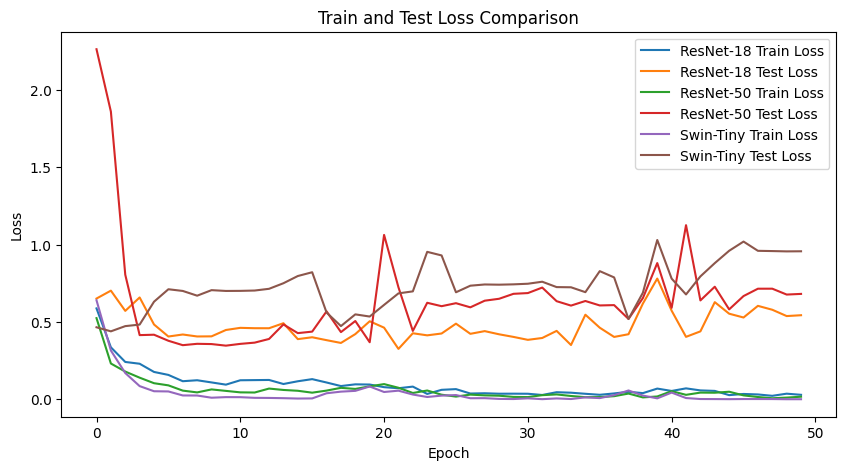

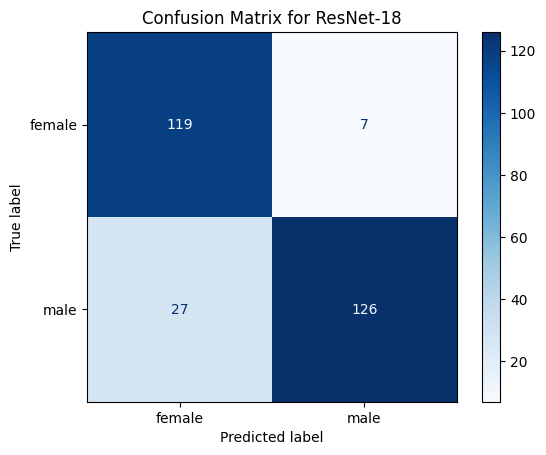

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


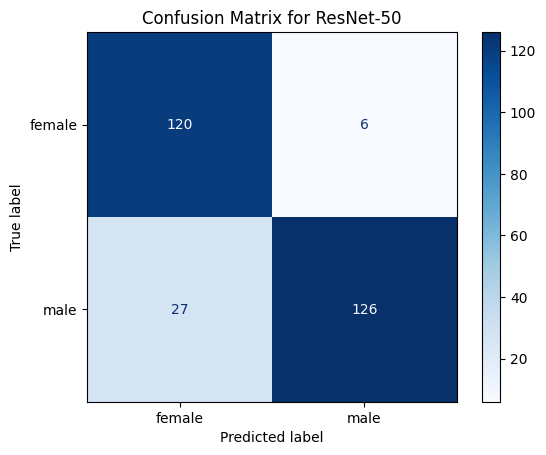

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


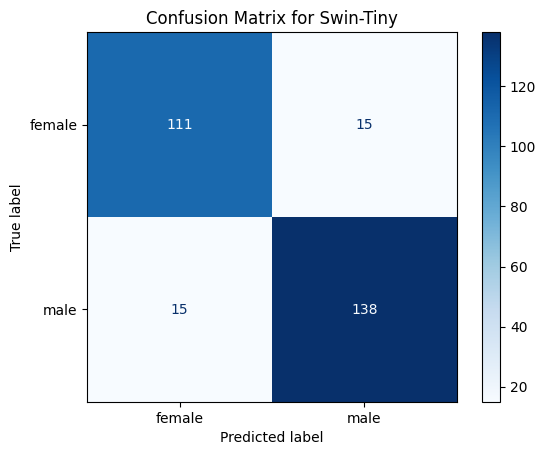

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


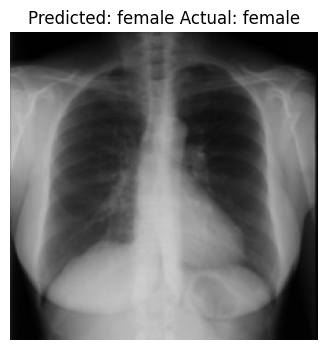

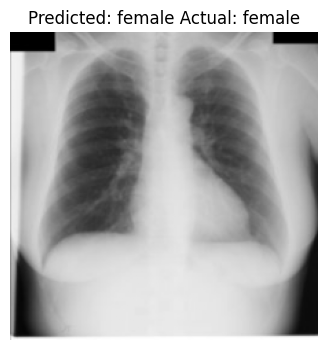

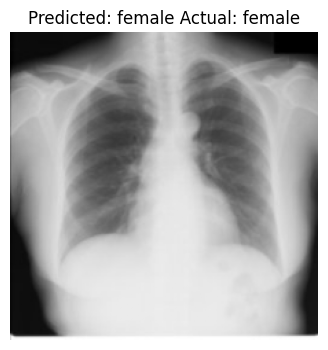

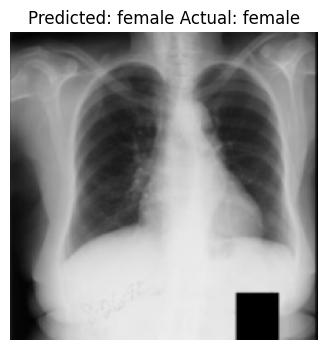

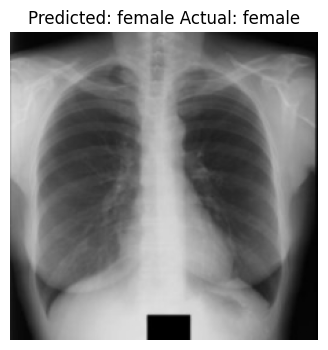

In [ ]:
# Plot loss comparison
def plot_loss_comparison(train_loss_resnet18, test_loss_resnet18, train_loss_resnet50, test_loss_resnet50, train_loss_swin_tiny, test_loss_swin_tiny):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_resnet18, label='ResNet-18 Train Loss')
    plt.plot(test_loss_resnet18, label='ResNet-18 Test Loss')
    plt.plot(train_loss_resnet50, label='ResNet-50 Train Loss')
    plt.plot(test_loss_resnet50, label='ResNet-50 Test Loss')
    plt.plot(train_loss_swin_tiny, label='Swin-Tiny Train Loss')
    plt.plot(test_loss_swin_tiny, label='Swin-Tiny Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss Comparison')
    plt.legend()
    plt.show()


plot_loss_comparison(train_losses_resnet18, test_losses_resnet18, train_losses_resnet50, test_losses_resnet50, train_losses_swin_tiny, test_losses_swin_tiny)


# Plot confusion matrices for all models
plot_confusion_matrix(resnet18, gender_dataloaders['test'], 'ResNet-18')
plot_confusion_matrix(resnet50, gender_dataloaders['test'], 'ResNet-50')
plot_swin_confusion_matrix(swin_tiny, swin_dataloaders['test'], 'Swin-Tiny')

# Visualization of Predictions
import random

def imshow(inp, title=None, figsize=(4, 4)):
    """Display the image with a smaller size."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=figsize)  # Set the figure size to make the photo smaller
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axes for better visualization
    plt.pause(0.001)  # Pause to allow the plot to be updated

# Get a batch of images and labels from the test DataLoader
inputs, classes = next(iter(gender_dataloaders['test']))

# Move inputs to the appropriate device
inputs = inputs.to(device)

# Get model predictions
outputs = resnet18(inputs)  # You can choose any trained model here
_, preds = torch.max(outputs, 1)

# Randomly select a few images to display
num_images = 5  # Number of images to display
selected_indices = random.sample(range(inputs.size(0)), num_images)

# Display the randomly selected images
for j in selected_indices:
    imshow(inputs.cpu().data[j], title='Predicted: {} Actual: {}'.format(class_names[preds[j]], class_names[classes[j]]))
